# Using ResNet to predict PDE (with support by finite difference method & finite element method)

## Importing the packages

In [6]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

from matplotlib import pyplot as plt

In [7]:
# ==========
# helping methods
# ==========

# generate a list from lower and upper bound
def gen_list(p0, pn, delta, dig=5):
    ret = []
    i = p0
    while i < pn:
        ret.append(float(i))
        i += delta
        i = round(i, dig)
    return ret

# padding and zero padding
def padding(origin, a_list, b_list):
    return a_list + origin + b_list

def zero_padding(origin, num):
    zero_list = [0 for i in range(num)]
    return padding(origin, zero_list, zero_list)

# trainning pairs
def gen_pair(u, x, t, length=3, num=1000):
    pairs = []
    for i in range(num):
        r = random.randint(0, t-2)
        current_t = u[r]
        next_t = u[r+1]
        p = random.randint(length, x-1-length)
        train = current_t[p-length:p+length+1]
        solu = next_t[p]
        pair = {'input': train, 'solu': solu}
        pairs.append(pair)
    return pairs

In [33]:
# ==================
# testing the helping methods
# ==================
test_list = []
for i in range(100):
    test_list.append([j for j in range(100)])
print(test_list)

pairs = gen_pair(test_list, 100, 100, num=10)
print(pairs)

test_list = []
for i in range(100):
    test_list.append([i for j in range(100)])
print(test_list)

pairs = gen_pair(test_list, 100, 100, num=10)
print(pairs)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 

## Setting up the domain of the function

In [8]:
# [boundary] define the 1-d boundary of $x$
a = -0.5
b = 0.5
x0 = a
xn = b

In [9]:
# [gap] set up the gap
N = 20
h = (xn - x0) / N
delta_x = h

In [10]:
# [boundary] time boundary
T = 0.5
t0 = -0.5
tn = T

In [11]:
# [gap] time gap
n = 10
delta_t = (tn - t0) / n

In [13]:
# list of $x$ and $t$
x = gen_list(x0, xn, delta_x)
t = gen_list(t0, tn, delta_t)

## ResNets

In [8]:
# restnet
class ResNet(nn.Module):
    def __init__(self, a, b, c, d):
        super(ResNet, self).__init__()
        self.linear1 = nn.Linear(2, a)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(a, b)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(b, c)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(c, d)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(d, 2)
        self.relu5 = nn.ReLU()
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        out = self.relu5(out)
        return out + x

    def load_model(self, save_path):
        self.load_state_dict(torch.load(save_path))

    def save_model(self, save_path):
        torch.save(self.state_dict(), save_path)

## Problem 1

\begin{array}{l}
u_{t}+u_{x}=0 \\
u(x, 0)=\sin x \\
u(a, t)=u(b, t)=0
\end{array}

$$
\frac{u_{j}^{m+1}-u_{j}^{m}}{\Delta t}-\frac{u_{j+1}^{m}-u_{j}^{m}}{\Delta x}=0
$$

$$
u_{j}^{m+1}=\frac{u_{j+1}^{m}-u_{j}^{m}}{\Delta x} \Delta t+u_{j}^{m}
$$

In [9]:
# initial conditions, t=0
u1_x0 = np.sin(x).tolist()

# calcuate the equation value for next time step    (｡•ᴗ-)_
# u_tpp = u time ++     ∠(ᐛ」∠)＿
def u1_tpp(input_list):
    output_list = []
    for index, element in enumerate(input_list[:-1]):
        u_jp1 = input_list[index+1]
        u_j = element
        out = (u_jp1 - u_j) * delta_t / delta_x + u_j
        output_list.append(out)
    return output_list

In [10]:
u1 = [u1_x0]

# temp = u[0]
# temp = padding(temp, [], [np.sin(x0+delta_x).tolist()])
# temp1 = u_tpp(temp)

for i in range(len(t)):
    temp = u1[i]
    temp = padding(temp, [], [np.sin(x0+delta_x).tolist()])
    temp = u1_tpp(temp)
    u1.append(temp)

In [11]:
for a in u1:
    print(len(a))
    print(a)

20
[-0.8414709848078965, -0.7833269096274834, -0.7173560908995228, -0.644217687237691, -0.5646424733950354, -0.479425538604203, -0.3894183423086505, -0.29552020666133955, -0.19866933079506122, -0.09983341664682815, 0.0, 0.09983341664682815, 0.19866933079506122, 0.29552020666133955, 0.3894183423086505, 0.479425538604203, 0.5646424733950354, 0.644217687237691, 0.7173560908995228, 0.7833269096274834]
20
[0.3214105188003653, 0.536089464931729, 0.7454119823371127, 0.9472865896154219, 1.139696222421612, 1.3207183873068467, 1.488544370637569, 1.641497310664227, 1.7780489521696001, 1.8968349162897349, 1.996668332936563, 2.0765516996114894, 2.1356868481206277, 2.173482919607559, 2.1895622682197002, 2.1837642344208503, 2.156146750248148, 2.1069857604743265, 2.036772465458735, -30.549749475471852]
20
[4.61498944142764, 4.722539813039402, 4.782904127903296, 4.795479245739225, 4.7601395201263035, 4.677238053921292, 4.54760317117073, 4.37253014077169, 4.153768234572295, 3.893503249226299, 3.59433566

In [12]:
# training set
gen_pair(u1, x=len(u1[0]), t=len(u1), length=3, num=10)

[-17.249285746294753, -18.68341631549214, -19.930868364932635, -20.9791777658448, -21.8178701573526, -22.438565602272803] -47.77240062923734
[0.9472865896154219, 1.139696222421612, 1.3207183873068467, 1.488544370637569, 1.641497310664227, 1.7780489521696001] 4.795479245739225
[77.29144667766136, -41594826072.93001, 273252601009.0047, -769217237542.4739, 1202837421485.452, -1128419777097.011] -231.25193269543297
[114.87509566762998, -0.9002273060404491, -116.6524676694948, -231.25193269543297, -343.530829849676, -452.3833120737237] -2476.829875780294
[-0.29552020666133955, -0.19866933079506122, -0.09983341664682815, 0.0, 0.09983341664682815, 0.19866933079506122] 0.9472865896154219
[-5.0391594423180734, -5.934296100303285, -6.770139233275194, -7.538337372935038, -8.231214937412602, -13007.225004406144] -15.642806015613564
[0.536089464931729, 0.7454119823371127, 0.9472865896154219, 1.139696222421612, 1.3207183873068467, 1.488544370637569] 4.795479245739225
[] 4.795479245739225
[2.13568684

In [13]:
model1 = ResNet()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion1 = nn.MSELoss()
model1.train()
scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=30, gamma = 0.95)

In [14]:
num_epochs1 = 60
list_of_loss1 = []
counter1 = 1
for epoch in range(0, num_epochs1):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-14-11223e21cd01>, line 5)

## Problem 2 --- heat equation; diffusion equation

### Analysis

\begin{array}{l}
u_{t}+u_{xx}=0 \\
u(x, 0)=\sin \pi x \\
u(a, t)=u(b, t)=0
\end{array}

$$
\frac{u_{j}^{m+1}-u_{j}^{m}}{\Delta t}-\frac{u_{j+1}^{m}-2 u_{j}^{m}+u_{j-1}^{m}}{\Delta x^{2}}=0
$$

$$
u_{j}^{m+1}=\frac{u_{j+1}^{m}-2 u_{j}^{m}+u_{j-1}^{m}}{\Delta x^{2}} \Delta t+u_{j}^{m}
$$

### Analytical/Exact solution

In [14]:
# the analytical representation of exact solution
def heat_equ_analytical_solu(x, t):
    return np.sin(np.pi * x) * np.exp(-np.power(np.pi, 2) * t)

In [67]:
# calculate the exact solution
c = []
for ti in t:
    c_t = []
    for xj in x:
        c_x = (xj, ti)
        c_t.append(c_x)
    c.append(c_t)

In [68]:
print(c)

[[(-1.0, -0.1), (-0.9, -0.1), (-0.8, -0.1), (-0.7, -0.1), (-0.6, -0.1), (-0.5, -0.1), (-0.4, -0.1), (-0.3, -0.1), (-0.2, -0.1), (-0.1, -0.1), (0.0, -0.1), (0.1, -0.1), (0.2, -0.1), (0.3, -0.1), (0.4, -0.1), (0.5, -0.1), (0.6, -0.1), (0.7, -0.1), (0.8, -0.1), (0.9, -0.1)], [(-1.0, -0.08), (-0.9, -0.08), (-0.8, -0.08), (-0.7, -0.08), (-0.6, -0.08), (-0.5, -0.08), (-0.4, -0.08), (-0.3, -0.08), (-0.2, -0.08), (-0.1, -0.08), (0.0, -0.08), (0.1, -0.08), (0.2, -0.08), (0.3, -0.08), (0.4, -0.08), (0.5, -0.08), (0.6, -0.08), (0.7, -0.08), (0.8, -0.08), (0.9, -0.08)], [(-1.0, -0.06), (-0.9, -0.06), (-0.8, -0.06), (-0.7, -0.06), (-0.6, -0.06), (-0.5, -0.06), (-0.4, -0.06), (-0.3, -0.06), (-0.2, -0.06), (-0.1, -0.06), (0.0, -0.06), (0.1, -0.06), (0.2, -0.06), (0.3, -0.06), (0.4, -0.06), (0.5, -0.06), (0.6, -0.06), (0.7, -0.06), (0.8, -0.06), (0.9, -0.06)], [(-1.0, -0.04), (-0.9, -0.04), (-0.8, -0.04), (-0.7, -0.04), (-0.6, -0.04), (-0.5, -0.04), (-0.4, -0.04), (-0.3, -0.04), (-0.2, -0.04), (-0.1, 

In [70]:
f = []
for ti in c:
    f_t = []
    for xj in ti:
        f_x = heat_equ_analytical_solu(xj[0], xj[1])
        f_t.append(f_x)
    f.append(f_t)

In [71]:
print(f)

[[-3.2858090747829113e-16, -0.8291132145907564, -1.5770670509659215, -2.170646576320285, -2.5517480910004235, -2.6830667234590573, -2.551748091000423, -2.170646576320285, -1.5770670509659213, -0.829113214590756, 0.0, 0.829113214590756, 1.5770670509659213, 2.170646576320285, 2.551748091000423, 2.6830667234590573, 2.5517480910004235, 2.170646576320285, 1.5770670509659215, 0.8291132145907564], [-2.6972178808893904e-16, -0.6805931010533895, -1.2945650074047041, -1.7818158710664653, -2.0946501826270705, -2.202445540026152, -2.09465018262707, -1.7818158710664653, -1.294565007404704, -0.6805931010533893, 0.0, 0.6805931010533893, 1.294565007404704, 1.7818158710664653, 2.09465018262707, 2.202445540026152, 2.0946501826270705, 1.7818158710664653, 1.2945650074047041, 0.6805931010533895], [-2.2140617824759343e-16, -0.5586775859435608, -1.0626679172393383, -1.4626369087529822, -1.7194328088473094, -1.8079186456188432, -1.7194328088473092, -1.4626369087529822, -1.062667917239338, -0.5586775859435605,

In [15]:
x_mesh, t_mesh = np.meshgrid(x, t)
func_value = heat_equ_analytical_solu(x_mesh, t_mesh)
print(func_value)
print(type(func_value))

[[-1.39045637e+02 -1.37333754e+02 -1.32240259e+02 -1.23890569e+02
  -1.12490283e+02 -9.83201126e+01 -8.17289746e+01 -6.31253981e+01
  -4.29674647e+01 -2.17515298e+01  0.00000000e+00  2.17515298e+01
   4.29674647e+01  6.31253981e+01  8.17289746e+01  9.83201126e+01
   1.12490283e+02  1.23890569e+02  1.32240259e+02  1.37333754e+02]
 [-5.18233987e+01 -5.11853667e+01 -4.92869811e+01 -4.61749864e+01
  -4.19260103e+01 -3.66446767e+01 -3.04610295e+01 -2.35273307e+01
  -1.60143109e+01 -8.10696566e+00  0.00000000e+00  8.10696566e+00
   1.60143109e+01  2.35273307e+01  3.04610295e+01  3.66446767e+01
   4.19260103e+01  4.61749864e+01  4.92869811e+01  5.11853667e+01]
 [-1.93149869e+01 -1.90771874e+01 -1.83696442e+01 -1.72097794e+01
  -1.56261527e+01 -1.36577582e+01 -1.13530645e+01 -8.76882058e+00
  -5.96865921e+00 -3.02152965e+00  0.00000000e+00  3.02152965e+00
   5.96865921e+00  8.76882058e+00  1.13530645e+01  1.36577582e+01
   1.56261527e+01  1.72097794e+01  1.83696442e+01  1.90771874e+01]
 [-7.19

In [ ]:
plt.plot(func_value)

In [4]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(x,y):
    return (1-(x**2+y**3))*exp(-(x**2+y**2)/2)
 
x = arange(-3.0,3.0,0.1)
y = arange(-3.0,3.0,0.1)
X,Y = meshgrid(x, y) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid
print(Z)
print(type(Z))

[[ 0.00234479  0.00324714  0.00444356 ...  0.00600968  0.00444356
   0.00324714]
 [ 0.00271656  0.00378003  0.00519529 ...  0.00705412  0.00519529
   0.00378003]
 [ 0.00307523  0.00430508  0.00594913 ...  0.00811726  0.00594913
   0.00430508]
 ...
 [-0.00803313 -0.01055955 -0.01374627 ... -0.01772211 -0.01374627
  -0.01055955]
 [-0.00660186 -0.00869247 -0.01133452 ... -0.01463719 -0.01133452
  -0.00869247]
 [-0.00536864 -0.00707941 -0.00924518 ... -0.0119572  -0.00924518
  -0.00707941]]
<class 'numpy.ndarray'>


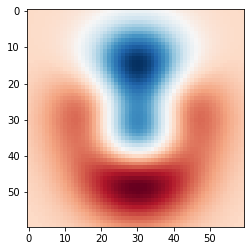

In [16]:
im = imshow(Z,cmap=cm.RdBu) # drawing the function
# adding the Contour lines with labels
# cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
# clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
# colorbar(im) # adding the colobar on the right
# latex fashion title
# title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')
# show()

### Trainning ResNet

\begin{array}{l}
u_{t}+u_{xxx}=0 \\
u(x, 0)=\sin x \\
u(a, t)=u(b, t)=0
\end{array}